***

<center><u><H1>Data pre-processing</H1></u></center>

***
***
# 1 Introduzione

La probabilità di avere dati anomali è significativa al giorno d'oggi, a causa della loro quantità e della eterogeneità delle fonti. Inoltre, i dati sono spesso incompleti e non hanno lo stesso formato o, nella migliore delle ipotesi, un design uniforme. Dato che un'elevata qualità dei dati è fondamentale per ottenere modelli precisi e predizioni accurate, il processamento dei dati prima della modellizzazione è divenuto un aspetto chiave della Data Science.

Per comprendere la centralità delle operazioni che andiamo ora ad esplorare, basti pensare che tipicamente un Data Scientist spende tra il 45% e il 60% del tempo nella fase di data pre-processing.

Data **wrangling** e data **pre-processing** sono alcuni dei termini che si incontrano e hanno varie interpretazioni nel mondo della Data Science: alcuni li considerano sinonimi e altri come operazioni ben distinte, con anche delle sfumature intermedie.

In generale, il data pre-processing indica il processo di conversione dei dati dal loro formato grezzo iniziale in un altro formato più adatto a future elaborazioni ed analisi. Ad alto livello, le operazioni da eseguire sono le seguenti:
- data cleaning (o cleansing): gestione di dati mancanti, outlier, pulizia dal rumore e correzione di dati inconsistenti
- data transformation: trasformazione dei dati in un formato opportuno per il modelling
- data integration: per integrare i dati provenienti da diverse fonti mantenendo accuratezza e velocità di calcolo il più possibile inalterate
- data reduction: l'obiettivo è la riduzione del dataset in modo da utilizzare le informazioni davvero essenziali, senza intaccare l'integrità del dataset o i risultati

Prima di tutto, importiamo i moduli che ci occorrono e il dataset precedente:

In [1]:
import pandas as pd # per la gestione del dataset
import numpy as np # per le operazioni matematiche e sul dataset
import seaborn as sns # grafica
from sklearn.impute import SimpleImputer # per la gestione degli outlier
from sklearn.compose import ColumnTransformer # encoding
from sklearn.preprocessing import OneHotEncoder # encoding
from sklearn.preprocessing import LabelEncoder # encoding

sns.set_style("darkgrid")
sns.set_palette("pastel")

Importiamo il dataset come un DataFramd di Pandas:

In [47]:
df = pd.read_csv("data_preproc.csv")
df

Country   Age   Salary Purchased
0   France  44.0  72000.0        No
1    Spain  27.0  48000.0       Yes
2  Germany  30.0  54000.0        No
3    Spain  38.0  61000.0        No
4  Germany  40.0      NaN       Yes
5   France  35.0  58000.0       Yes
6    Spain   NaN  52000.0        No
7   France  48.0  79000.0       Yes
8        ?  50.0  83000.0        No
9   France  37.0  67000.0       Yes

# 2 Data cleaning

## 2.1 Dati mancanti

Ci sono molti motivi per cui possono mancare dei dati nel nostro dataset:
- un fallimento nel caricare il file
- dati corrotti o non leggibili
- una raccolta incompleta
- ...
 
E' sempre una buona pratica cercare di capire perché mancano dei dati, in quanto la loro assenza potrebbe causare dei problemi per la data analysis anche se è possibile gestirli in modo artificiale. Possono infatti introdurre dei bias nella nostra analisi e portare a delle predizioni sbagliate. La loro opportuna comprensione, poi, è in ogni caso fondamentale per poterli gestire nel modo migliore.

I dati mancanti sono tipicamente classificati in una delle seguenti 3 categorie:

- **Missing At Random** (MAR): il motivo per cui il valore manca non è legato al suo valore, ma legato ad altre variabili (ad esempio giovani di 16 anni che non controllano la pressione regolarmente come gli adulti)
- **Missing Completely At Random** (MCAR): la mancanza del dato non è legata a nessuna variabile (ad esempio risposte opzionali mancanti in un sondaggio sulla soddisfazione dei clienti)
- **Missing Not At Random (MNAR)**: la mancanza del dato è legata al suo valore (ad esempio se il sondaggio prevede la comunicazione dello stipendio, delle persone con stipendi molto grandi potrebbero non volerlo rivelare)

La categoria più pericolosa è la MNAR, perché una gestione non corretta dei dati mancanti può portare a dei bias significativi nell'analisi.

Una volta identificati i dati mancanti, essi possono essere gestiti in diversi modi:
- eliminazione
    - dell'osservazione
    - della feature
- sostituzione
    - valor medio
    - basata sulla frequenza
    - interpolazione
    - costante
    - back-/forward-fill
    - ...
- lasciare il dato mancante

**Non c'è una scelta ottimale**: dipende dai dati e dallo scenario. Se i dati mancanti sono sulla variabile dipendente, ci sono buone probabilità che convenga eliminare le osservazioni dato che cercare di dedurne un valore andrebbe ad introdurre un bias pericoloso nella nostra analis. L’eliminazione di una osservazione può essere anche decisa in base a quante feature sono mancanti, ovvero se una certa (elevata) percentuale di dati è mancante.


### 2.1.1 Identificazione

Il modulo Pandas mette mette a disposizione alcuni metodi molto utili per identificare e gestire i dati mancanti. Prima di tutto, ricorriamo al metodo [isnull()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html) che fornisce un dataframe contenente solo dati booleani (True dove il dato è mancante, False altrimenti):

In [21]:
missing_data = df.isnull()
missing_data

Country    Age  Salary  Purchased
0    False  False   False      False
1    False  False   False      False
2    False  False   False      False
3    False  False   False      False
4    False  False    True      False
5    False  False   False      False
6    False   True   False      False
7    False  False   False      False
8    False  False   False      False
9    False  False   False      False

Osservando il dataset di partenza e il dataset missing_data, vediamo che i NaN sono stati effettivamente individuati. Tuttavia, i caratteri anomali ('?') vengono letti come dati leciti..! Probabilmente procedendo nelle analisi saremmo arrivati o a degli errori di compilazione o a dei risultati non corretti. A quel punto, analizzando a ritroso tutto il progetto, avremmo trovato il problema; spesso, infatti, nella Data Science si deve iterare tra le varie fasi del progetto per risolvere dei problemi o migliorare degli aspetti. In ogni caso, con delle variabili di tipo categorico, è sempre una buona pratica stampare i loro valori unici tramite il metodo [unique()](https://pandas.pydata.org/docs/reference/api/pandas.unique.html) o il metodo [value_counts()](https://www.geeksforgeeks.org/getting-frequency-counts-of-a-columns-in-pandas-dataframe/):



In [7]:
df['Country'].unique()

array(['France', 'Spain', 'Germany', '?'], dtype=object)

In [8]:
df['Country'].value_counts()

Country
France     4
Spain      3
Germany    2
?          1
Name: count, dtype: int64

Una volta che ci siamo accorti, verificando su tutte le feature, che ci sono dei dati non riconosciuti come mancanti, possiamo ricorrere al metodo [replace()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) per renderli tali. Questo metodo permette di definire un valore in ingresso che va poi interpretato come un nan (not a number). Questo metodo lo chiamiamo con il keyword argument **inplace = True** in modo che la modifica si rifletta direttamente sul dataset di partenza (senza sprecare memoria con delle copie):

In [48]:
df.replace(to_replace = "?", value = np.nan, inplace=True)
df

Country   Age   Salary Purchased
0   France  44.0  72000.0        No
1    Spain  27.0  48000.0       Yes
2  Germany  30.0  54000.0        No
3    Spain  38.0  61000.0        No
4  Germany  40.0      NaN       Yes
5   France  35.0  58000.0       Yes
6    Spain   NaN  52000.0        No
7   France  48.0  79000.0       Yes
8      NaN  50.0  83000.0        No
9   France  37.0  67000.0       Yes

Possiamo notare come ora anche sulla feature Country ci sono i dati mancanti riportati come nan. Possiamo stampare di nuovo i dati mancanti come prima o anche ottenere la loro percentuale sul totale delle osservazioni, un dato che può essere significativo per la loro gestione: 

In [10]:
missing_data = df.isnull()
missing_data

Country    Age  Salary  Purchased
0    False  False   False      False
1    False  False   False      False
2    False  False   False      False
3    False  False   False      False
4    False  False    True      False
5    False  False   False      False
6    False   True   False      False
7    False  False   False      False
8     True  False   False      False
9    False  False   False      False

In [12]:
for column in missing_data.columns:
    count_missing = sum(missing_data[column])
    if count_missing > 0:
        print(f"{column}: {count_missing} ({count_missing/missing_data.shape[0]:.2%}) dati mancanti.")

Country: 1 (10.00%) dati mancanti.
Age: 1 (10.00%) dati mancanti.
Salary: 1 (10.00%) dati mancanti.


### 2.1.2 Gestione

L'approccio per gestire i dati mancanti dipende, in generale, dalla loro distribuzione:
- eliminazione dell'osservazione: si può eliminare la riga quando si hanno abbastanza osservazioni, per cui eliminarne alcune non crea problemi. Questo approccio è più adatto ai casi MAR e MCAR, piuttosto che al MNAR (rischiamo di introdurre un grande bias). Inoltre, sarebbe opportuno eliminare osservazioni con diverse feature mancanti, se possibile;
- eliminazione della feature: approccio molto drastico, che possiamo applicare quando su una feature abbiamo la maggior parte dei dati mancanti, altrimenti non va nemmeno considerato;
- sostituzione: si sostituiscono tutti i valori mancanti con un altro valore. Vi sono diversi valori di sostituzione, ad esempio: il valore precedente, il valore successivo, il valore non mancante più vicino, interpolazione lineare, interpolazione cubica, una costante fornita dall'utente, ...
- ignorare il dato mancante: non si cambia nulla, prestando però attenzione quando è necessario calcolare delle statistiche, nonché allenare algoritmi di AI/ML, perché i NaN rischiano di produrre dei NaN in uscita.

Per l'eliminazione, si ricorre al metodo [dropna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) che, appunto, rimuove i dati mancanti in base ai nan presenti. I keyword argument più interessanti da tenere a mente sono:
- ignore_index: se True, effettua automaticamente un reset dell'indice (altrimenti si deve fare esplicitamente)
- thresh: permette di inserire una soglia per la cancellazione (ad esempio almeno 3 NaN)
- inplace: se True, modifica il dataframe su cui è chiamato il metodo (sconsigliato a meno che non si sia assolutamente certi di ciò che si sta facendo)
- axis: asse per la cancellazione (0 per la riga, 1 per la colonna)

Iniziamo a vedere la cancellazione di una riga:

In [13]:
df_del_row = df.dropna(axis = 0, ignore_index = True, inplace = False)
df_del_row

Country   Age   Salary Purchased
0   France  89.0  72000.0        No
1    Spain  27.0  48000.0       Yes
2  Germany  30.0  54000.0        No
3    Spain  38.0  61000.0        No
4   France  35.0  58000.0       Yes
5   France  48.0  79000.0       Yes
6   France  37.0  67000.0       Yes

La cancellazione di una colonna è invece molto drastica, per cui va presa con le molle. Se la applichiamo in modo non ponderato, rischiamo di trovarci con un dataset praticamente inutilizzabile:

In [14]:
df_del_col = df.dropna(axis = 1, ignore_index = True, inplace = False)
df_del_col

Purchased
0        No
1       Yes
2        No
3        No
4       Yes
5       Yes
6        No
7       Yes
8        No
9       Yes

Potrebbe essere utile definire una (relativamente alta) percentuale di nan per colonna per eliminarla, da cui ricavare il valore di thresh per questo metodo. Vediamo un esempio: 

In [15]:
nan_per_col_ratio = 0.5
nan_per_col = round(nan_per_col_ratio * df.shape[0])
df_del_col = df.dropna(axis = 1, ignore_index = True, inplace = False, thresh = nan_per_col)
df_del_col

Country   Age   Salary Purchased
0   France  89.0  72000.0        No
1    Spain  27.0  48000.0       Yes
2  Germany  30.0  54000.0        No
3    Spain  38.0  61000.0        No
4  Germany  40.0      NaN       Yes
5   France  35.0  58000.0       Yes
6    Spain   NaN  52000.0        No
7   France  48.0  79000.0       Yes
8      NaN  50.0  83000.0        No
9   France  37.0  67000.0       Yes

Per quanto riguarda la sostituzione, la strategia da adottare dipende dal tipo di dato. Per valori numerici, si può creare un oggetto [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) del modulo sklearn.impute ed applicarlo al dataframe col metodo fit_transform():

In [49]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean') # median, constant, most_frequent
df[['Age', 'Salary']] = imputer.fit_transform(df[['Age', 'Salary']]) # solo colonne numeriche
df

Country        Age        Salary Purchased
0   France  44.000000  72000.000000        No
1    Spain  27.000000  48000.000000       Yes
2  Germany  30.000000  54000.000000        No
3    Spain  38.000000  61000.000000        No
4  Germany  40.000000  63777.777778       Yes
5   France  35.000000  58000.000000       Yes
6    Spain  38.777778  52000.000000        No
7   France  48.000000  79000.000000       Yes
8      NaN  50.000000  83000.000000        No
9   France  37.000000  67000.000000       Yes

Per valori di tipo categorico, seguiamo un approccio simile, ma ricorrendo alla moda (ovvero il valore più probabile):

In [10]:
most_freq_value = df['Country'].value_counts().idxmax()
most_freq_value

'France'

In [50]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df[['Country']] = imputer.fit_transform(df[['Country']])
df

Country        Age        Salary Purchased
0   France  44.000000  72000.000000        No
1    Spain  27.000000  48000.000000       Yes
2  Germany  30.000000  54000.000000        No
3    Spain  38.000000  61000.000000        No
4  Germany  40.000000  63777.777778       Yes
5   France  35.000000  58000.000000       Yes
6    Spain  38.777778  52000.000000        No
7   France  48.000000  79000.000000       Yes
8   France  50.000000  83000.000000        No
9   France  37.000000  67000.000000       Yes

Nel codice appena utilizzato, il metodo [value_count()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) fornisce il conto delle categorie, mentre il metodo [idxmax()](https://pandas.pydata.org/docs/reference/api/pandas.Series.idxmax.html) ritorna la label del valore che si presenta più volte (ovvero della moda).

In un ipotetico progetto di Machine Learning, l'obiettivo potrebbe essere quello di predire la variabile Purchased. Essa si chiama Dependent Variable (DV) e, qualora vi fossero dei dati mancanti, il discorso sarebbe più delicato. Infatti non avrebbe senso sostituire i dati mancanti con dei valori calcolati da noi, dato che rischieremmo di introdurre dei bias nelle analisi. Pertanto, se i dati mancanti sono in numero relativamente limitato, è più opportuno eliminare quelle osservazioni.

## 2.2 Outlier

Un outlier è un dato che cade al di fuori di un certo range atteso o che non segue un pattern atteso, generando quindi il sospetto che sia errato. Gli outlier possono essere causati da:
- errori nel registrare i dati
- corruzione dei dati
- malfunzionamenti dei sensori/strumenti
- anomalie
- variazioni naturali dei dati
- ...

**Non è detto che siano dati da elminare**: potrebbero rappresentare dei punti interessanti che forniscono indicazioni su dei comportamenti inaspettati (ad esempio per la fraud detection o la classificazione delle email come spam). Tuttavia, la loro esclusione (anche solo temporanea) da delle figure o misure può rendere estramemente più chiara l'analisi, dato che possono introdurre un bias notevole, ad esempio, sulla deviazione standard o sulla media della distribuzione.

Non c'è una definizione univoca di outlier, in termini di differenza rispetto ai dati normali. Si tratta di un aspetto da valutare caso per caso. Da un punto di vista matematico, si possono identificare come:
- dati che cadono fuori da una distanza di $3\sigma$ dal valor medio, utile quando i dati sono approssimativamente normali ma poco preciso in presenza di outlier grandi o distribuzioni molto asimmetriche (skewness elevata)
- dati che cadono fuori da una distanza di $1.5IQR$ dal Q1 o Q3
- dati che cadono fuori da una distanza di 3 Mean Absolute Deviation (MAD) dalla mediana

Oltre a questo, analizzare l'andamento delle moving mean o moving median può aiutare nell'identificazione degli outlier, come punti che cadono fuori da tali andamenti.

Uno strumento molto utile per la loro identificazione è l'analisi visiva tramite **box plot**. Un box plot è un grafico orientato verticalmente dove:
- il box racchiude l'Interquartile Range (IQR), ovvero la differenza tra il 75mo ($Q_3$) e il 25mo ($Q_1$) percentile dei dati (racchiude quindi il 50% centrale dei dati);
- la linea nel box rappresenta la mediana ($Q_2$);
- i whisker rappresentano il minimo ($𝑄_1−1.5𝐼𝑄𝑅$) e il massimo ($𝑄_3+1.5𝐼𝑄𝑅$) valore dei dati non considerati come outlier
- gli outlier sono rappresentati come punti esterni ai whisker

Il modulo Seaborn fornice una funzione proprio per questo tipo di grafico:

<Axes: ylabel='Age'>

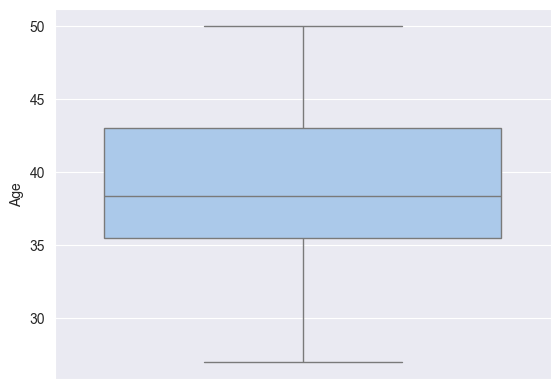

In [25]:
sns.boxplot(data = df, y = "Age")

<Axes: ylabel='Salary'>

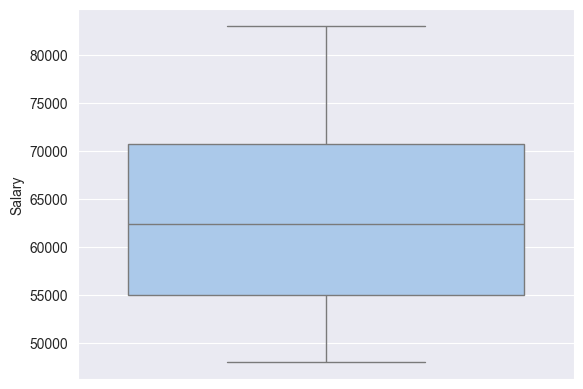

In [26]:
sns.boxplot(data = df, y = "Salary")

E' anche possibile raggruppare i box plot in base ad una seconda variabile, ad esempio per paese. Può essere molto utile per vedere quanto una certa feature può essere usata come discriminante per l'altra:

<Axes: xlabel='Country', ylabel='Age'>

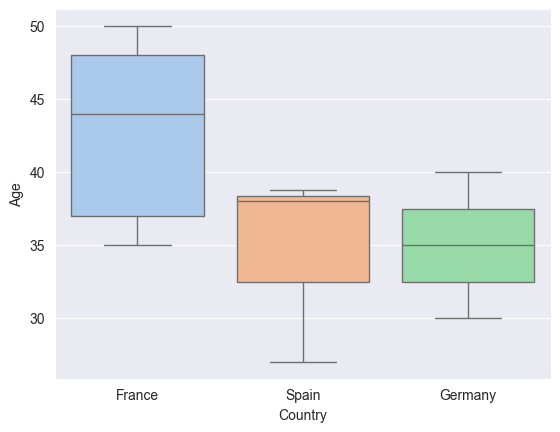

In [32]:
sns.boxplot(data = df, x = "Country", y = "Age", palette = "pastel", hue = "Country")

<Axes: xlabel='Country', ylabel='Salary'>

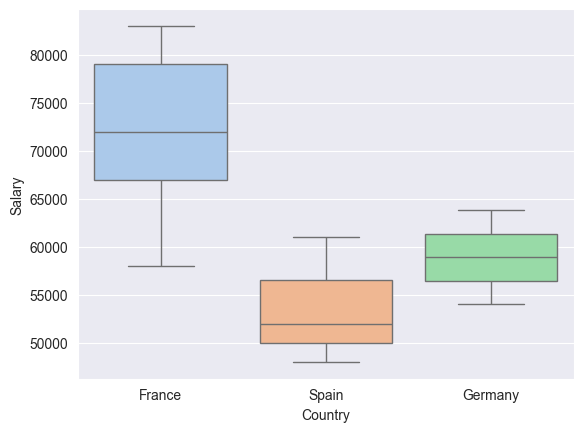

In [33]:
sns.boxplot(data = df, x = "Country", y = "Salary", palette = "pastel", hue = "Country")

La visualizzazione ci permette appunto di vedere se ci sono degli outlier. Potrebbe però non essere sufficiente per valutarne l'esatto numero o per identificare le rispettive osservazioni nel dataset, se dovessimo gestirli. Per fare questo, occorre confrontare ciascun dato con uno dei metodi elencati sopra. Rimanendo con i quartili: 

In [34]:
q1 = df[['Age', 'Salary']].quantile(0.25)
q1

Age          35.5
Salary    55000.0
Name: 0.25, dtype: float64

In [35]:
q2 = df[['Age', 'Salary']].quantile(0.5)
q2

Age          38.388889
Salary    62388.888889
Name: 0.5, dtype: float64

In [36]:
q3 = df[['Age', 'Salary']].quantile(0.75)
q3

Age          43.0
Salary    70750.0
Name: 0.75, dtype: float64

Possiamo vedere che questi valori sono gli stessi visualizzati nei box plot. Ora calcoliamo l'IQR e confrontiamo i dati delle colonne con i whisker del grafico:

In [37]:
iqr = q3 - q1
iqr

Age           7.5
Salary    15750.0
dtype: float64

In [38]:
df_numeric = df[['Age', 'Salary']]
iqr_outliers = df_numeric[((df_numeric < (q1 - 1.5*iqr)) | (df_numeric > (q3 + 1.5*iqr)))]
iqr_outliers

Age  Salary
0  NaN     NaN
1  NaN     NaN
2  NaN     NaN
3  NaN     NaN
4  NaN     NaN
5  NaN     NaN
6  NaN     NaN
7  NaN     NaN
8  NaN     NaN
9  NaN     NaN

Possiamo vedere che nessuno di questi dati è un outlier. Se avessimo voluto ottenere un dataframe booleano, basterebbe chiamare il metodo isnan:

In [39]:
np.isnan(iqr_outliers)

Age  Salary
0  True    True
1  True    True
2  True    True
3  True    True
4  True    True
5  True    True
6  True    True
7  True    True
8  True    True
9  True    True

Avremmo anche potuto farci stampare direttamente i dati individuati come outlier:

In [41]:
iqr_outliers = df_numeric[((df_numeric < (q1 - 1.5*iqr)) | (df_numeric > (q3 + 1.5*iqr))).any(axis=1)]
iqr_outliers

Empty DataFrame
Columns: [Age, Salary]
Index: []

## 2.3 Trasformazione dei dati

### 2.3.1 Formato

I dati potrebbero richiedere di venire formattati:
- per modificare l’unità di misura, o comunque renderli più facilmente interpretabili (ad esempio una velocità in miglia orarie potrebbe venire convertita in km orari, a seconda della nazionalità)
- per portarli ad un data type più idoneo per l’informazione contenuta (a volte un dato numerico potrebbe essere stato salvato o letto come stringa ha senso convertirlo in int o float)

Nel dataset che stiamo utilizzando, non abbiamo questa necessità, ma a puro titolo di esempio potremmo aggiungere una colonna con i salari in dollari e poi eliminare quella in euro. Dal punto di vista degli algoritmi di ML, sono lo stesso dato quindi è un errore lasciarle entrambe!

In [42]:
df['Salary_dollar'] = df['Salary'] * 1.09
df

Country        Age        Salary Purchased  Salary_dollar
0   France  44.000000  72000.000000        No   78480.000000
1    Spain  27.000000  48000.000000       Yes   52320.000000
2  Germany  30.000000  54000.000000        No   58860.000000
3    Spain  38.000000  61000.000000        No   66490.000000
4  Germany  40.000000  63777.777778       Yes   69517.777778
5   France  35.000000  58000.000000       Yes   63220.000000
6    Spain  38.777778  52000.000000        No   56680.000000
7   France  48.000000  79000.000000       Yes   86110.000000
8   France  50.000000  83000.000000        No   90470.000000
9   France  37.000000  67000.000000       Yes   73030.000000

Torniamo al dataset originario eliminando questa colonna:

In [43]:
del df['Salary_dollar']
df

Country        Age        Salary Purchased
0   France  44.000000  72000.000000        No
1    Spain  27.000000  48000.000000       Yes
2  Germany  30.000000  54000.000000        No
3    Spain  38.000000  61000.000000        No
4  Germany  40.000000  63777.777778       Yes
5   France  35.000000  58000.000000       Yes
6    Spain  38.777778  52000.000000        No
7   France  48.000000  79000.000000       Yes
8   France  50.000000  83000.000000        No
9   France  37.000000  67000.000000       Yes

### 2.3.2 Data encoding

La maggior parte dei modelli statistici ed algoritmi di ML non prendono in ingresso delle variabili categoriche o stringhe, ma solo numeriche. Essi infatti si basano spesso sul calcolo di distanze o altre forme di similarità tra variabili: come gestiamo questa situazione quando abbiamo delle variabili categoriche?

Con il **data encoding** convertiamo in tipo numerico dei data type categorici tramite dummy variable. Ci sono due approcci:
- **label encoding**: si converte ogni categoria con un numero
    - tipicamente si parte da 1 fino a 𝑁, dove 𝑁 è il numero di categorie, per non introdurre bias
    - potrebbe essere necessario comunque dare più peso ad alcune categorie, modificando la numerazione
- **one-hot encoding**: conversione in sequenze binarie non ordinate
    - le categorie potrebbero non avere un ordinamento e introdurlo potrebbe introdurre bias indesiderati

Va anche tenuto presente che, per applicare gli algoritmi di ML, potrebbe essere necessario codificare anche la variabile dipendente! Gli algoritmi spesso cercano di ricavare un valore numerico come output, per cui vanno addestrati con tali input.

#### 2.3.2.1 Label encoding

Per il label encoding, possiamo:
- creare un oggetto [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) del modulo sklearn.preprocessing
- applicare il metodo fit_transform sulle colonne che ci interessa trasformare
 


In [51]:
df_backup = df.copy()
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])
df

Country        Age        Salary Purchased
0        0  44.000000  72000.000000        No
1        2  27.000000  48000.000000       Yes
2        1  30.000000  54000.000000        No
3        2  38.000000  61000.000000        No
4        1  40.000000  63777.777778       Yes
5        0  35.000000  58000.000000       Yes
6        2  38.777778  52000.000000        No
7        0  48.000000  79000.000000       Yes
8        0  50.000000  83000.000000        No
9        0  37.000000  67000.000000       Yes

In [52]:
label_encoder = LabelEncoder()
df['Purchased'] = label_encoder.fit_transform(df['Purchased'])
df

Country        Age        Salary  Purchased
0        0  44.000000  72000.000000          0
1        2  27.000000  48000.000000          1
2        1  30.000000  54000.000000          0
3        2  38.000000  61000.000000          0
4        1  40.000000  63777.777778          1
5        0  35.000000  58000.000000          1
6        2  38.777778  52000.000000          0
7        0  48.000000  79000.000000          1
8        0  50.000000  83000.000000          0
9        0  37.000000  67000.000000          1

#### 2.3.2.2 One-hot encoding

La feature che abbiamo trasformato non ha un ordinamento implicito: si tratta di nazioni ed ognuna dovrebbe venire trattata allo stesso modo delle altre. Per quanto, il label encoding non è la miglior scelta possibile.

Ricorrendo al one-hot encoding, fondamentalmente convertiamo in codice binario ogni valore della feature. Ci sono due approcci per farlo:
- soluzione 1: metodo [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) di Pandas

In [53]:
df = df_backup
df = df.join(pd.get_dummies(df['Country']))
df

Country        Age        Salary Purchased  France  Germany  Spain
0   France  44.000000  72000.000000        No    True    False  False
1    Spain  27.000000  48000.000000       Yes   False    False   True
2  Germany  30.000000  54000.000000        No   False     True  False
3    Spain  38.000000  61000.000000        No   False    False   True
4  Germany  40.000000  63777.777778       Yes   False     True  False
5   France  35.000000  58000.000000       Yes    True    False  False
6    Spain  38.777778  52000.000000        No   False    False   True
7   France  48.000000  79000.000000       Yes    True    False  False
8   France  50.000000  83000.000000        No    True    False  False
9   France  37.000000  67000.000000       Yes    True    False  False

A questo punto, cancelliamo la colonna che abbiamo modificato e spostiamo le nuove feature all'inizio:

In [54]:
del df['Country']
df = df[['France', 'Germany', 'Spain', 'Age', 'Salary', 'Purchased']]
df

France  Germany  Spain        Age        Salary Purchased
0    True    False  False  44.000000  72000.000000        No
1   False    False   True  27.000000  48000.000000       Yes
2   False     True  False  30.000000  54000.000000        No
3   False    False   True  38.000000  61000.000000        No
4   False     True  False  40.000000  63777.777778       Yes
5    True    False  False  35.000000  58000.000000       Yes
6   False    False   True  38.777778  52000.000000        No
7    True    False  False  48.000000  79000.000000       Yes
8    True    False  False  50.000000  83000.000000        No
9    True    False  False  37.000000  67000.000000       Yes

- soluzione 2: oggetto [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) del modulo sklearn.preprocessing, utilizzando un oggetto [ColumnTransformer](https://scikit-learn.org/1.5/modules/generated/sklearn.compose.ColumnTransformer.html) del modulo sklearn.compose



In [56]:
df = df_backup
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['Country'])], remainder='passthrough')
df = ct.fit_transform(df)
df

array([[1.0, 0.0, 0.0, 44.0, 72000.0, 'No'],
       [0.0, 0.0, 1.0, 27.0, 48000.0, 'Yes'],
       [0.0, 1.0, 0.0, 30.0, 54000.0, 'No'],
       [0.0, 0.0, 1.0, 38.0, 61000.0, 'No'],
       [0.0, 1.0, 0.0, 40.0, 63777.77777777778, 'Yes'],
       [1.0, 0.0, 0.0, 35.0, 58000.0, 'Yes'],
       [0.0, 0.0, 1.0, 38.77777777777778, 52000.0, 'No'],
       [1.0, 0.0, 0.0, 48.0, 79000.0, 'Yes'],
       [1.0, 0.0, 0.0, 50.0, 83000.0, 'No'],
       [1.0, 0.0, 0.0, 37.0, 67000.0, 'Yes']], dtype=object)

NOTA: vanno reinseriti i nomi delle colonne se ancora necessari perché ColumnTransformer ritorna un ndarray.
